# Week 5 GANs

## Description

This notebook outlines the analysis and model building procedure for the Kaggle competition found at https://www.kaggle.com/competitions/gan-getting-started.

There are about 300 photos of monet samples and 7038 samples of photos to turn into monets. The goal is to generate images from real photos that look like painting from the famous artist using GANs (Generative Adversarial Networks).

Link to Github: https://github.com/WyattHough/msds/blob/main/deep_learning/Week%205/Week5.ipynb

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import PIL
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
autoTone = tf.data.experimental.AUTOTUNE   
print(tf.__version__)

Number of replicas: 1
2.12.0


In [9]:
photoFilenames = tf.io.gfile.glob('../../../data/gan-getting-started/photo_tfrec/*.tfrec')
print('Photo tfRecord Files:', len(photoFilenames))
monetFilenames = tf.io.gfile.glob('../../../data/gan-getting-started/monet_tfrec/*.tfrec')
print('Monet tfRecord Files:', len(monetFilenames))

Photo tfRecord Files: 20
Monet tfRecord Files: 5


In [11]:
imgSize = [256, 256]

def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = (tf.cast(img, tf.float32) / 127.5) - 1
    img = tf.reshape(img, [*imgSize, 3])
    return img

def read_tfrecord(exm):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    exm = tf.io.parse_single_example(exm, tfrecord_format)
    img = decode_image(exm['image'])
    return img

def load_dataset(fileNames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(fileNames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=autoTone)
    return dataset

In [12]:
monetDs = load_dataset(monetFilenames, labeled=True).batch(1)
photoDs = load_dataset(photoFilenames, labeled=True).batch(1)
exmMonet = next(iter(monetDs))
exmPhoto = next(iter(photoDs))

2023-06-24 13:18:10.771755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]
2023-06-24 13:18:11.023420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20]
	 [[{{node Placeholder/_0}}]]


## Exploratory Data Analysis

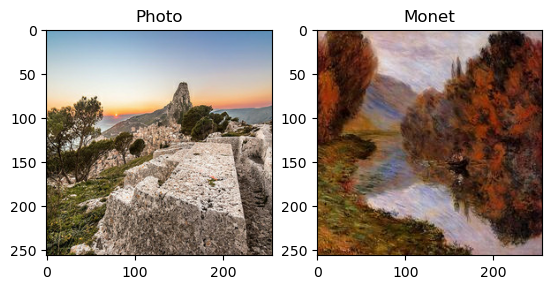

In [13]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(exmPhoto[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(exmMonet[0] * 0.5 + 0.5)

In [16]:
outputChannels = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gammaInit))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [17]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])
    downStack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4), 
        downsample(256, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
        downsample(512, 4), 
    ]

    upStack = [
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4, apply_dropout=True), 
        upsample(512, 4), 
        upsample(256, 4),
        upsample(128, 4), 
        upsample(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(outputChannels, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs
    
    skips = []
    
    for down in downStack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    for up, skip in zip(upStack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) 
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zeroPad1 = layers.ZeroPadding2D()(down3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zeroPad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gammaInit)(conv)

    leakyRelu = layers.LeakyReLU()(norm1)

    zeroPad2 = layers.ZeroPadding2D()(leakyRelu) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zeroPad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [19]:
with strategy.scope():
    monetGenerator = Generator() 
    photoGenerator = Generator() 

    monetDiscriminator = Discriminator() 
    photoDiscriminator = Discriminator()

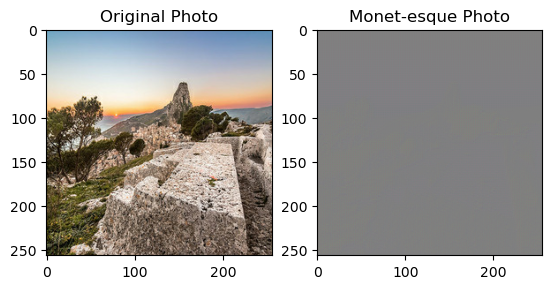

In [20]:
toMonet = monetGenerator(exmPhoto)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(exmPhoto[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(toMonet[0] * 0.5 + 0.5)
plt.show()

In [21]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [22]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [23]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [24]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [25]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Model and Results

In [26]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [28]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=2
)

2023-06-24 13:22:46.920126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype string and shape [20]
	 [[{{node Placeholder/_8}}]]
2023-06-24 13:22:46.925422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5]
	 [[{{node Placeholder/_0}}]]


Epoch 1/2
300/300 [==============================] - 2394s 8s/step - monet_gen_loss: 5.3815 - photo_gen_loss: 5.5153 - monet_disc_loss: 0.6325 - photo_disc_loss: 0.6144
Epoch 2/2
300/300 [==============================] - 2220s 7s/step - monet_gen_loss: 3.7270 - photo_gen_loss: 3.7131 - monet_disc_loss: 0.6481 - photo_disc_loss: 0.6651


## Results

2023-06-24 16:01:47.504898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20]
	 [[{{node Placeholder/_0}}]]


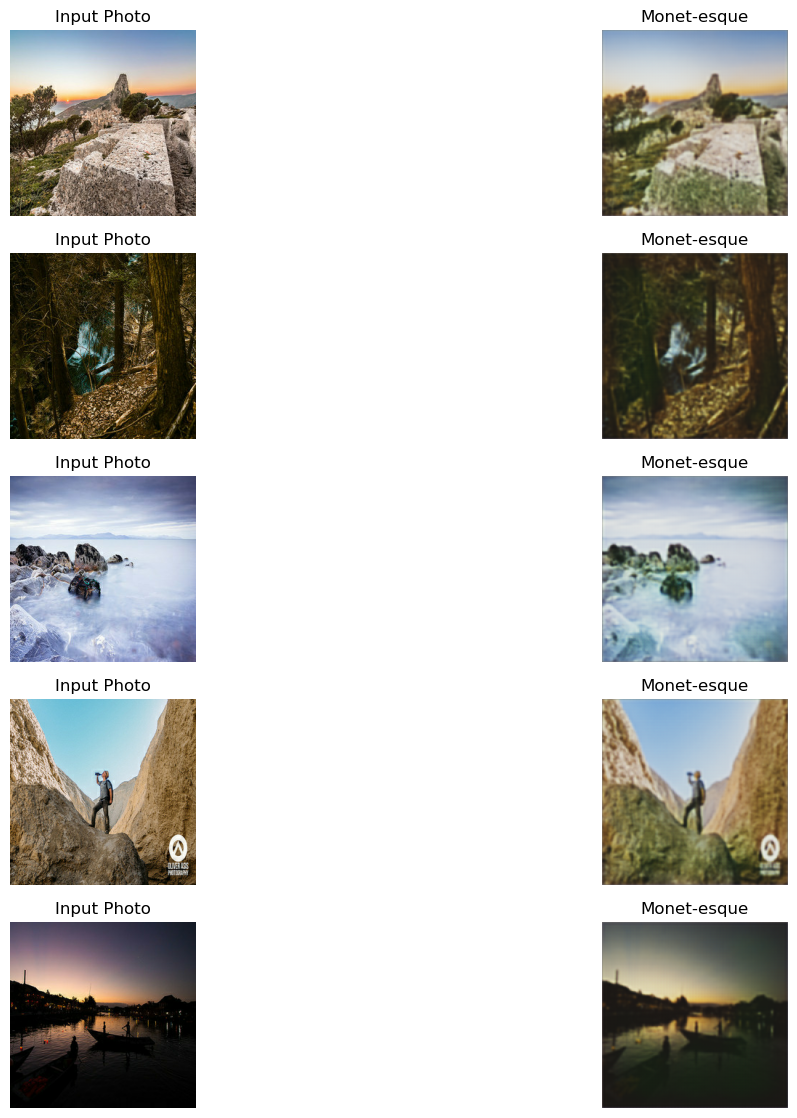

In [29]:
_, ax = plt.subplots(5, 2, figsize=(14, 14))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [30]:
i = 1
for img in photoDs:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

## Conclusion

In the end the model did an okay job producing monets photos. It did obscure the image and made it look more abstract in a way that Monet painting are styled however the photos looked to just be blurred and certainly would not be mistaken for a Monet by anyone. I used the Adam optimizer to help the model converge faster which helped decrease training time. I was resource limited running the training on an underpowered laptop but in the future I would like to experiment with different loss functions to improve performance.